# Hierarchical forecasting with categories

This is very similar to the hierarchical model described in 4.  
The difference here is that, instead of aggregating at the global level and predicting with that, we will aggregate using some predefined category

In [3]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [4]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

In [ ]:
df['month'] = df['date'].dt.month
top_100_families = df['family'].value_counts().index[:20].drop(['Botas de montaña', 'Chándales Urban'])

# Create the family_temp column
df['family_temp'] = df['family'].apply(lambda x: x if x in top_100_families else 'fake_family')

In [6]:
# 1. Separate original data using a categorical column (e.g., 'brand' or 'family')
categorical_column = "family_temp"  # Or any other column for separation

# 2. Prepare the model and processing functions
def preprocess_and_forecast(df_category, target_col="total_revenue", forecasting_horizon=12, frequency="ME"):
    """
    Preprocess and forecast data for a given category.
    """
    # 2.1. Preprocessing steps
    df_category = utils_preprocessing.set_types(df_category)
    df_category = utils_preprocessing.filter_dates(df_category, date="2024-09-01")
    df_category = utils_preprocessing.remove_outliers(df_category, window_size=5, threshold=2)

    df_monthly = utils_preprocessing.aggregate_data(df_category, frequency=frequency)
    df_monthly = utils_preprocessing.fill_in_missing_dates(
        df_monthly, 
        group_col=["brand", "family"], 
        date_col="date", 
        freq=frequency
    )
    df_monthly = utils_features.features_time_related(df_monthly, frequency=frequency)

    # 2.2. Split the data into train and test
    train_end_date = df_monthly['date'].max() - pd.DateOffset(months=12)
    train_data = df_monthly[df_monthly['date'] <= train_end_date]
    test_data = df_monthly[df_monthly['date'] > train_end_date]

    # 2.3. Train-test split for model
    X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(
        df_monthly, forecasting_horizon=forecasting_horizon, target_col=target_col
    )

    # 2.4. Set hyperparameters for the model
    hyperparameters = {
        "trend": "mul",           
        "seasonal": "mul",       
        "seasonal_periods": 12, 
        "steps_ahead": 12, 
    }

    # 2.5. Train the model
    exp_smoothing_model = utils_models.HierarchicalModel(forecasting_model="ExponentialSmoothing", hyperparameters=hyperparameters)
    exp_smoothing_model.train(X_train=train_data, y_train=None)
    exp_smoothing_model.evaluate_agg_forecast(test_data)

    # 2.6. Make predictions
    df_predictions = exp_smoothing_model.predict(X_test)

    # 2.7. Merge predictions with the test data
    df_predictions = pd.merge(test_data[['date', 'brand', 'family', 'total_revenue']], 
                              df_predictions, 
                              on=['date', 'brand', 'family'], 
                              how='left')
    
    return df_predictions



/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3

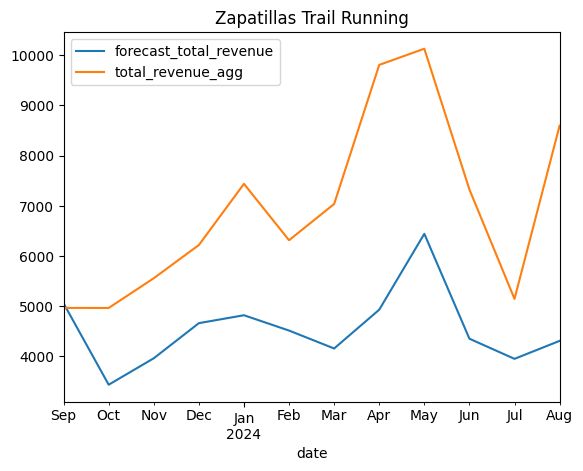

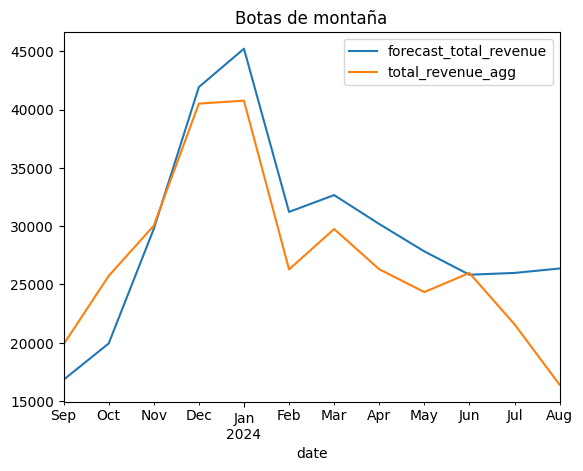

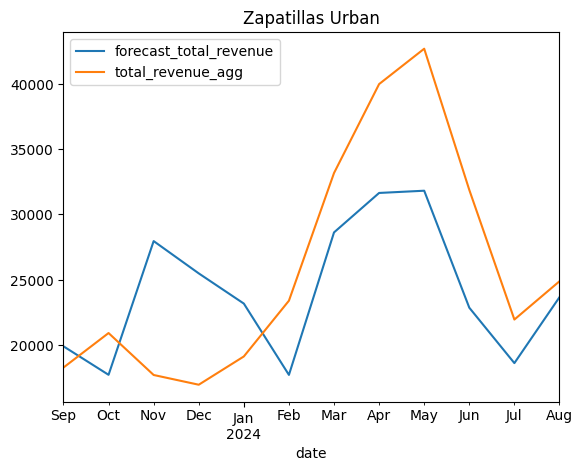

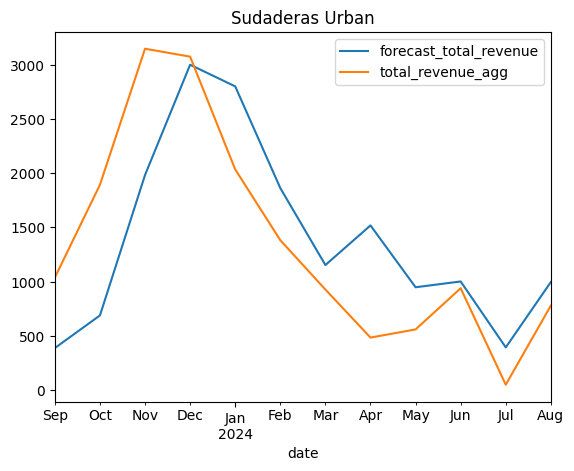

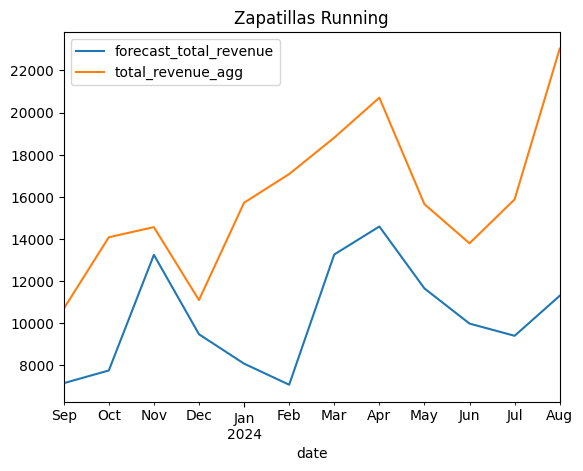

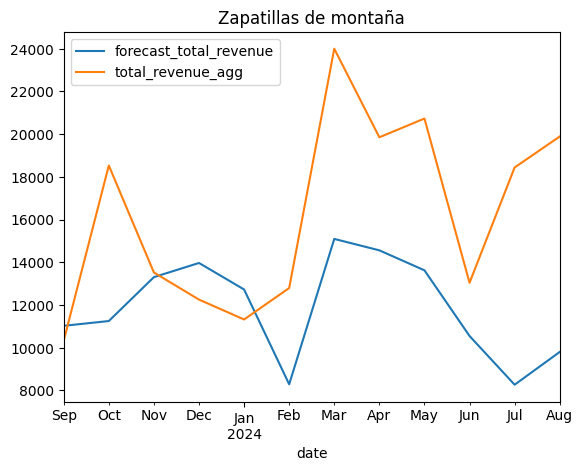

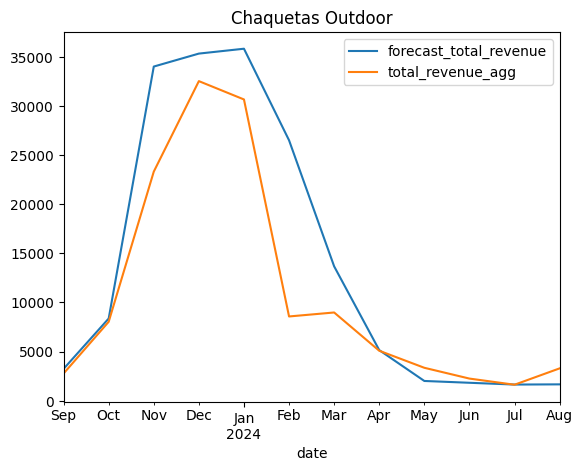

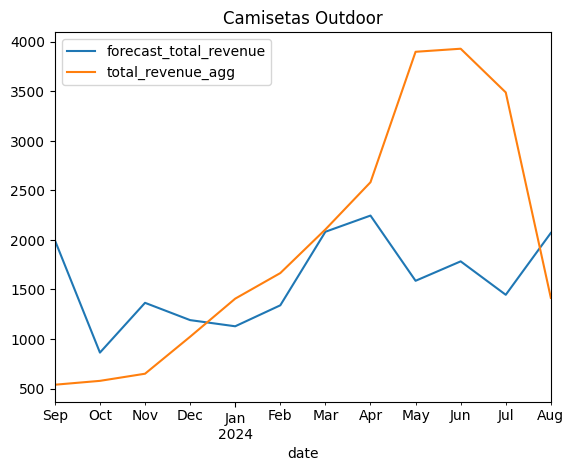

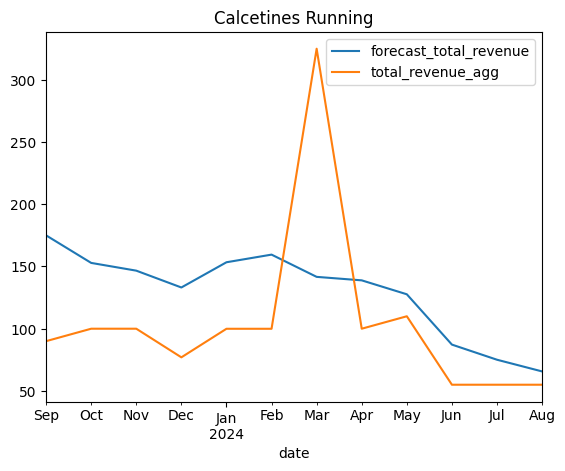

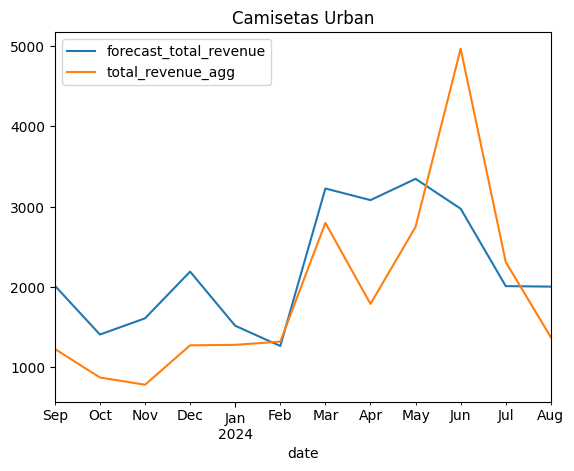

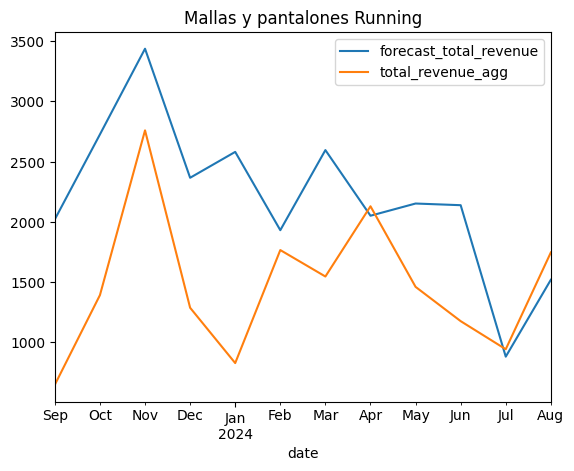

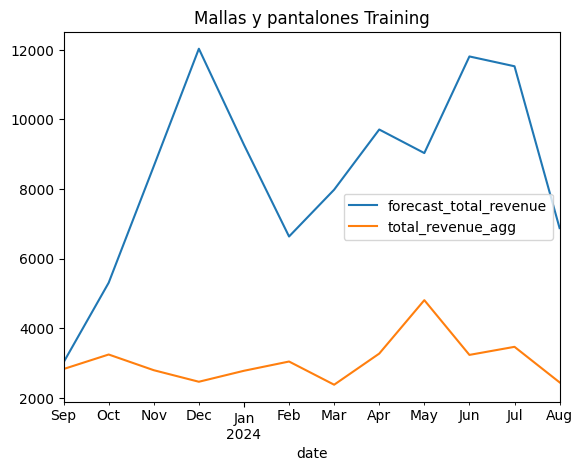

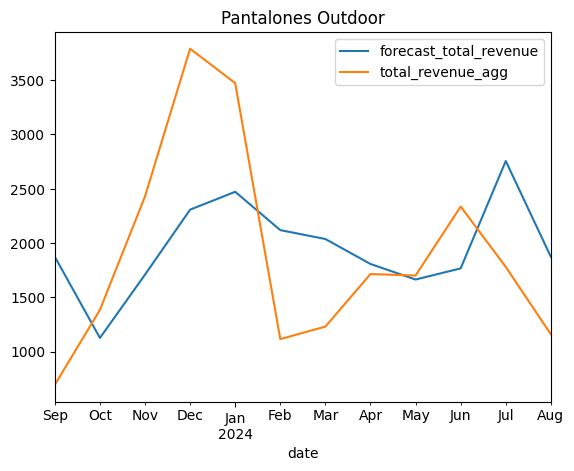

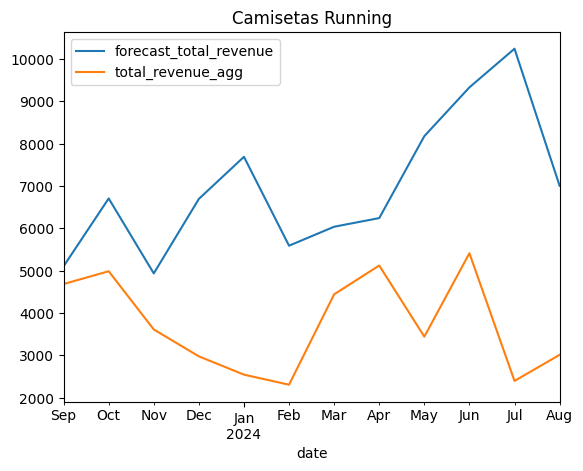

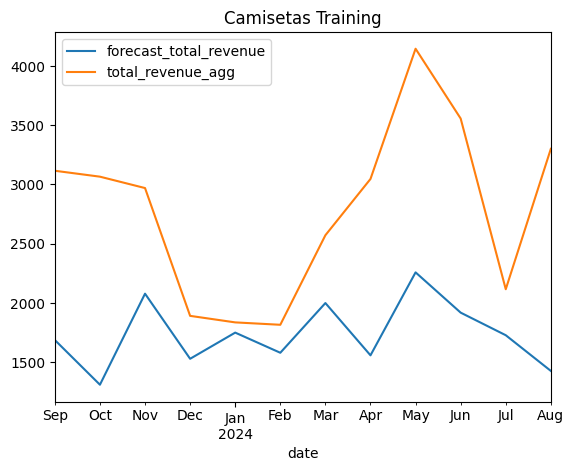

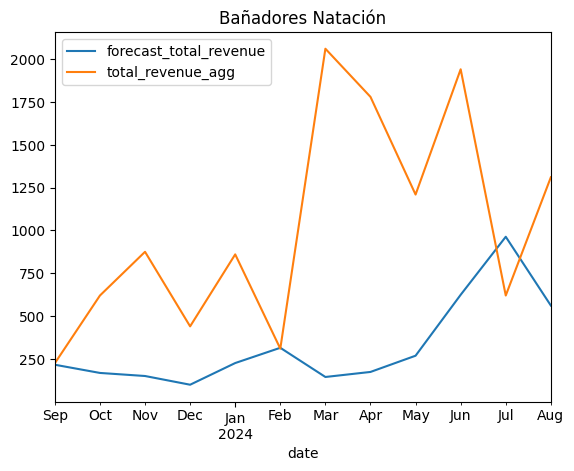

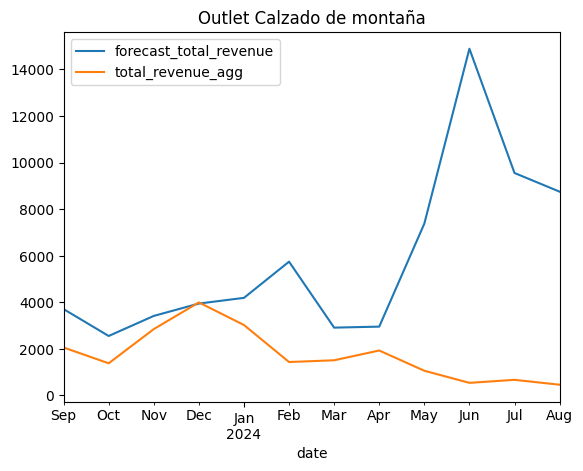

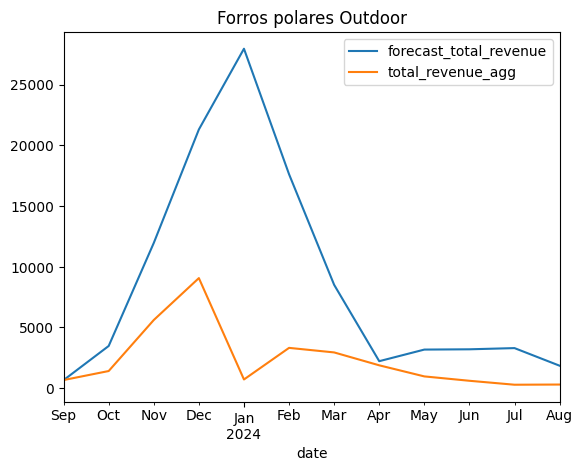

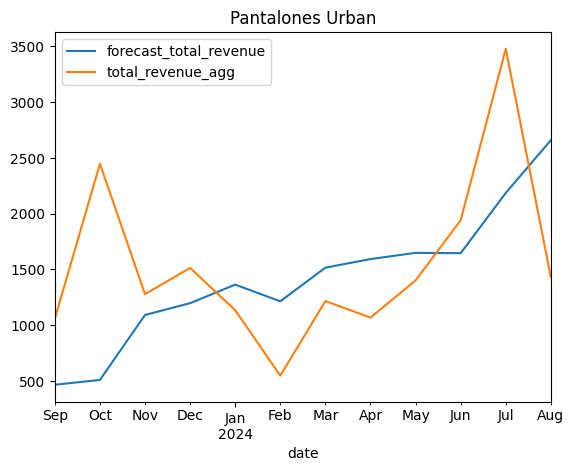

In [7]:

# 3. Apply the process to each category (e.g., 'brand')
result_list = []  # To store predictions for each category

for category_value in df[categorical_column].unique():
    df_category = df[df[categorical_column] == category_value]
    df_predictions = preprocess_and_forecast(df_category, target_col="total_revenue")
    df_predictions['category'] = category_value  # Add a column for the category (e.g., 'brand')
    result_list.append(df_predictions)

# 4. Combine predictions from all categories into a single DataFrame
df_all_predictions = pd.concat(result_list, ignore_index=True)

In [8]:
hyperparameters = {
    "order": (1, 1, 1),            
    "seasonal_order": (1, 1, 1, 12),  
    "steps_ahead": 12       
}
sarima_model = utils_models.HierarchicalModel(forecasting_model="Sarima", hyperparameters=hyperparameters)
df_all_predictions = df_all_predictions.rename(columns={'total_revenue': 'y', 'forecast_revenue': 'y_pred'})
sarima_model.evaluate(df_all_predictions, metric='RMSE')
sarima_model.evaluate(df_all_predictions, metric='MAPE')

Average RMSE from cross-validation: 16832.9500
Average MAPE from cross-validation: 0.8300


0.83

<Axes: >

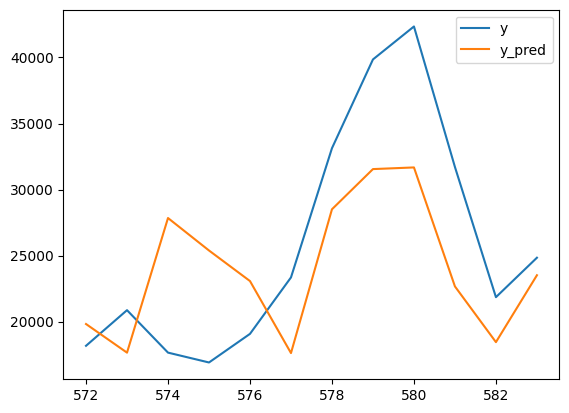

In [9]:
family = "Zapatillas Urban"
brand = "adidas"
df_all_predictions[(df_all_predictions["family"] == family) & (df_all_predictions["brand"] == brand)][["y", "y_pred"]].plot()